# Modeling the probability of transmission of PPRV lineage IV

## Introduction

#### import packages

In [2]:
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm
import pymc.sampling_jax
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, precision_score, recall_score, roc_auc_score, accuracy_score, auc
from sklearn.calibration import CalibrationDisplay
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

%load_ext watermark
%watermark -n -u -v -iv -w -p sklearn

Last updated: Fri Apr 19 2024

Python implementation: CPython
Python version       : 3.9.18
IPython version      : 8.12.0

sklearn: 1.4.0

matplotlib: 3.8.2
numpy     : 1.26.3
seaborn   : 0.13.2
pandas    : 2.2.0
arviz     : 0.17.0
pymc      : 5.10.3

Watermark: 2.4.3



#### import data

In [ ]:
# model 1 data 
df_bin = pd.read_excel("C:/Users/manhi/Documents/PPR_Senegal/python_scripts/null_model/serology_binomial_const.xlsx")

# model 2 data
df_seg_1 = pd.read_excel("C:/Users/manhi/Documents/PPR_Senegal/python_scripts/segmented_distance_models/input_data_seg/data_seg_30cm.xlsx") # distance <= 0.3 meters
df_seg_2 = pd.read_excel("C:/Users/manhi/Documents/PPR_Senegal/python_scripts/segmented_distance_models/input_data_seg/data_seg_1m.xlsx") # distance <= 1 meter
df_seg_3 = pd.read_excel("C:/Users/manhi/Documents/PPR_Senegal/python_scripts/segmented_distance_models/input_data_seg/data_seg_1.5m.xlsx") # distance <= 1.5 meters
df_seg_4 = pd.read_excel("C:/Users/manhi/Documents/PPR_Senegal/python_scripts/segmented_distance_models/input_data_seg/data_seg_2m.xlsx") # distance <= 2 meters

# model 3 data
df_env = pd.read_excel("C:/Users/manhi/Documents/PPR_Senegal/python_scripts/envelopes_models/envelopes_data_minutes/under_2m/enveloppe1_0.1_pivot.xlsx")
df_env1 = pd.read_excel("C:/Users/manhi/Documents/PPR_Senegal/python_scripts/envelopes_models/envelopes_data_minutes/under_2m/enveloppe1_0.1.xlsx")


## Models

### Model 1: Binomial 

In [ ]:
# import model's trace 

with open(r"C:\Users\manhi\Documents\PPR_Senegal\python_scripts\null_model\trace_binomiale.pkl", 'rb') as bin:
    trace_bin = pickle.load(bin)
    

In [ ]:
az.plot_posterior(trace_bin, hdi_prob=.95);

In [ ]:
az.summary(trace_bin, round_to=4)

In [ ]:
p_sample_bin = trace_bin.posterior["p"].stack(sample=("chain", "draw")).values
p_sample_bin = np.random.choice(p_sample_bin, size=1000)

N = df_bin.shape[0] 
M = len(p_sample_bin)

t = df_bin["Time"].values
n = df_bin["n"].values.astype(np.int32)

simulation_bin = np.zeros((N, M)) 

for i in range(M):
    p_i = p_sample_bin[i]
    p_tot = 1 - (1 - p_i)**t
    
    sim = np.random.binomial(n, p_tot)
    simulation_bin[:, i] = sim

simulation_bin_df = pd.DataFrame(simulation_bin, 
                  columns=[f"Sim_{i}" for i in range(1, M+1)])

In [ ]:
# Prepare observed data
datacal = df_bin[["Event", "n", "Positives"]]  
datacal.columns = ["Exp", "N", "obs"]
datacal.loc[:, 'sd'] = np.sqrt(datacal['obs'] * (datacal['N'] - datacal['obs']))

# Calculate summary stats
means = simulation_bin.mean(axis=1) 

quantiles = np.quantile(simulation_bin, q=[0.025, 0.25, 0.5, 0.75, 0.975], axis=1)

# Create dataframe
res = pd.DataFrame() 
res["Exp"] = datacal["Exp"]
res = pd.concat([res, pd.DataFrame(quantiles.T)], axis=1)
res["Mean"] = means

# Set column names  
res.columns = ["Exp", "CI2.5", "CI25", "Median", "CI75", "CI97.5", "Mean"] 

# Set dtypes
cols = res.columns[1:]
res[cols] = res[cols].astype(float)

In [ ]:
# Plotting the main line and points
plt.figure(figsize=(10, 8))
sns.lineplot(data=res, x='Exp', y='Mean', color='red')
sns.scatterplot(data=res, x='Exp', y='Mean', color='red')

# Adding confidence intervals (ribbons)
plt.fill_between(res['Exp'], res['CI2.5'], res['CI97.5'], color='red', alpha=0.2)
plt.fill_between(res['Exp'], res['CI25'], res['CI75'], color='red', alpha=0.4)

# Adding points and error bars from 'datacal'
sns.scatterplot(data=datacal, x='Exp', y='obs')
plt.errorbar(datacal['Exp'], datacal['obs'], yerr=datacal['sd'], fmt='none', ecolor='black')

# Setting labels and title
plt.title("New Infections by Experiment")
plt.xlabel("Exp")
plt.ylabel("New Infections")

# Setting y-limits and y-ticks
plt.ylim(0, 7)
plt.yticks(np.arange(0, 11, 1))

# Rotating x-axis labels
plt.xticks(rotation=90)

# Hiding the legend
plt.legend([],[], frameon=False)

plt.show()


### Model 2: Segmented distance

#### Importing traces for the segmented models

In [ ]:
# import model's traces

with open("C:/Users/manhi/Documents/PPR_Senegal/python_scripts/segmented_distance_models/trace_seg/trace_seg_0.3m.pkl", 'rb') as seg_0_3m:
    trace_seg_0_3m = pickle.load(seg_0_3m)

with open("C:/Users/manhi/Documents/PPR_Senegal/python_scripts/segmented_distance_models/trace_seg/trace_seg_1m.pkl", 'rb') as seg_1m:
    trace_seg_1m = pickle.load(seg_1m)

with open("C:/Users/manhi/Documents/PPR_Senegal/python_scripts/segmented_distance_models/trace_seg/trace_seg_1.5m.pkl", 'rb') as seg_1_5m:
    trace_seg_1_5m = pickle.load(seg_1_5m)

with open("C:/Users/manhi/Documents/PPR_Senegal/python_scripts/segmented_distance_models/trace_seg/trace_seg_2m.pkl", 'rb') as seg_2m:
    trace_seg_2m = pickle.load(seg_2m)

#### Sampling from the posterior distributions of the p parameter for the segmented models

In [ ]:
p_sample_seg_0_3m = trace_seg_0_3m.posterior["p"].stack(sample=("chain", "draw")).values
p_sample_seg_0_3m = np.random.choice(p_sample_seg_0_3m, size=1000)


p_sample_seg_1m = trace_seg_1m.posterior["p"].stack(sample=("chain", "draw")).values
p_sample_seg_1m = np.random.choice(p_sample_seg_1m, size=1000)


p_sample_seg_1_5m = trace_seg_1_5m.posterior["p"].stack(sample=("chain", "draw")).values
p_sample_seg_1_5m = np.random.choice(p_sample_seg_1_5m, size=1000)


p_sample_seg_2m = trace_seg_2m.posterior["p"].stack(sample=("chain", "draw")).values
p_sample_seg_2m = np.random.choice(p_sample_seg_2m, size=1000)

In [ ]:
# Sampling seg_0_3m
pred_seg_0_3m = []

for j in range(len(p_sample_seg_0_3m)):
    p_0_3m = p_sample_seg_0_3m[j]
    
    for i in range(len(df_seg_1)):
        p_ind_0_3m = 1 - (1-p_0_3m)**df_seg_1['time'].loc[i]
                
    pred_seg_0_3m.append(p_ind_0_3m)  

In [ ]:
# Sampling
pred_seg_1m = []

for j in range(len(p_sample_seg_1m)):
    p_1m = p_sample_seg_1m[j]
    
    for i in range(len(df_seg_2)):
        p_ind_1m = 1 - (1-p_1m)**df_seg_2['time'].loc[i]
                
    pred_seg_1m.append(p_ind_1m) 

In [ ]:
# Sampling
pred_seg_1_5m = []

for j in range(len(p_sample_seg_1_5m)):
    p_1_5m = p_sample_seg_1_5m[j]
    
    for i in range(len(df_seg_3)):
        p_ind_1_5m = 1 - (1-p_1_5m)**df_seg_3['time'].loc[i]
                
    pred_seg_1_5m.append(p_ind_1_5m) 

In [ ]:
# Sampling
pred_seg_2m = []

for j in range(len(p_sample_seg_2m)):
    p_2m = p_sample_seg_2m[j]
    
    for i in range(len(df_seg_4)):
        p_ind_2m = 1 - (1 - p_2m)**df_seg_4['time'].loc[i]
                
    pred_seg_2m.append(p_ind_2m) 

In [ ]:
from scipy import stats

mean = np.mean(p_sample_seg_0_3m) 

print("Mean", mean)
lower, upper = stats.norm.interval(confidence=0.95, loc=np.mean(p_sample_seg_0_3m) , scale=np.std(p_sample_seg_0_3m)/np.sqrt(len(p_sample_seg_0_3m)))

print("95% CI:", lower, upper)

In [ ]:
mean = np.mean(p_sample_seg_1m) 

print("Mean", mean)
lower, upper = stats.norm.interval(confidence=0.95, loc=np.mean(p_sample_seg_1m) , scale=np.std(p_sample_seg_1m)/np.sqrt(len(p_sample_seg_1m)))

print("95% CI:", lower, upper)

### Exposition time estimation

In [2]:
# mean
mean_seg_0_3m = 0.1796
mean_seg_1m = 0.0049
mean_seg_1_5m = 0.0026
mean_seg_2m = 0.002

# 95% HDI 
upper_0_3m, lower_0_3m = 0.2554, 0.1047
upper_1m, lower_1m = 0.0071, 0.0027
upper_1_5m, lower_1_5m = 0.0038, 0.0015
upper_2m, lower_2m = 0.0028, 0.0011

time = np.arange(1, 3000)

# proba
prob_seg_0_3m = 1 - (1 - mean_seg_0_3m)**time
prob_seg_1m = 1 - (1 - mean_seg_1m)**time
prob_seg_1_5m = 1 - (1 - mean_seg_1_5m)**time
prob_seg_2m = 1 - (1 - mean_seg_2m)**time

In [3]:
#segmented

# 0.95
a = np.log(0.05)/np.log(1 - 0.0011)
print(round(a))

# 0.5
b = np.log(0.5)/np.log(1 - 0.0011)
print(round(b))

2722
630


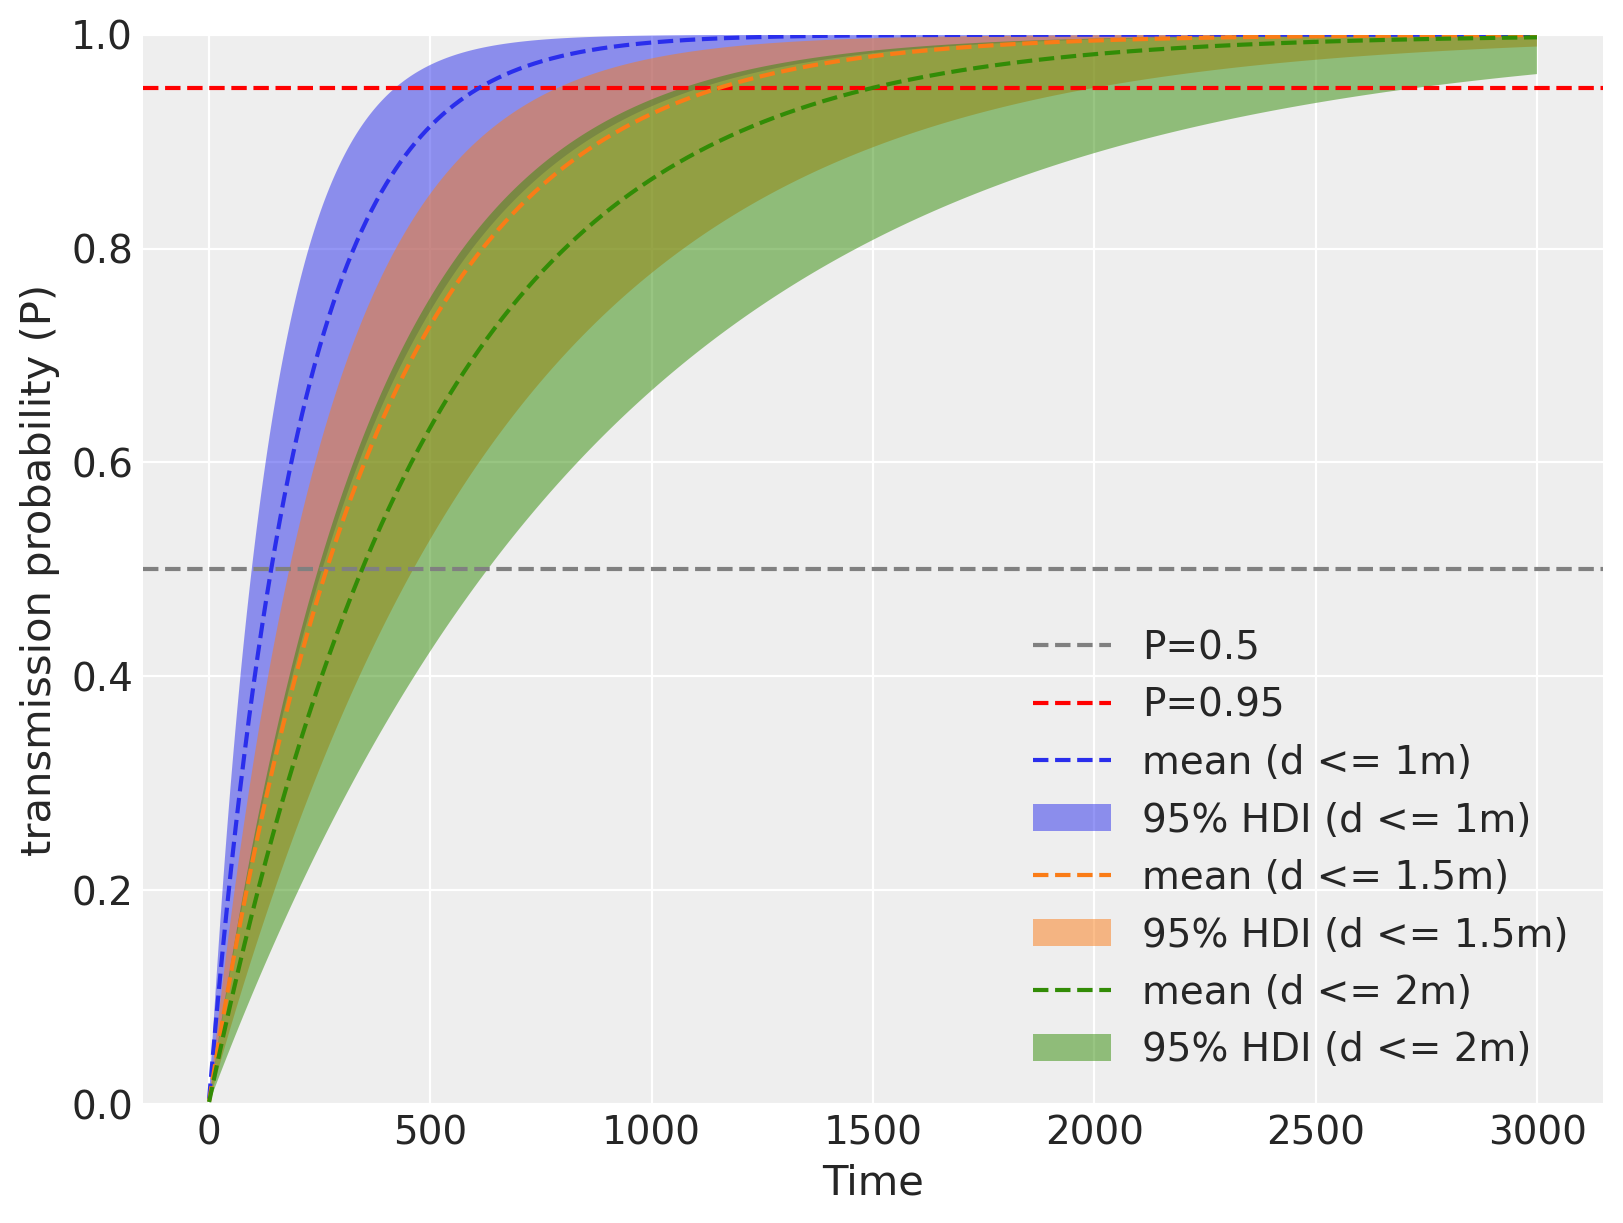

In [4]:
fig, ax = plt.subplots(figsize=(8,6))

ax.set_ylim([0, 1])
ax.axhline(0.5, color='gray', linestyle='--', label= 'P=0.5')
ax.axhline(0.95, color='red', linestyle='--', label= 'P=0.95')


ax.plot(time, prob_seg_1m, linestyle='--', label='mean (d <= 1m)')
ax.fill_between(time, 
                1 - (1 - lower_1m)**time, 
                1 - (1 - upper_1m)**time,
                alpha=0.5, label='95% HDI (d <= 1m)')

# curve for distance <= 1.5m
ax.plot(time, prob_seg_1_5m, linestyle='--', label='mean (d <= 1.5m)')
ax.fill_between(time, 
                1 - (1 - lower_1_5m)**time, 
                1 - (1 - upper_1_5m)**time,
                alpha=0.5, label='95% HDI (d <= 1.5m)')

# curve for distance <= 2m
ax.plot(time, prob_seg_2m, linestyle='--', label='mean (d <= 2m)')
ax.fill_between(time, 
                1 - (1 - lower_2m)**time, 
                1 - (1 - upper_2m)**time,
                alpha=0.5, label='95% HDI (d <= 2m)')

#ax.set_xticks(range(0, 1441, 10))
plt.legend()
plt.xlabel('Time')
plt.ylabel('transmission probability (P)')
#plt.title('Exposition time estimation: segmented')
plt.show()

### Model 3: Enveloppes

In [2]:
# mean_lambda
mean_lambda_1m = 0.3708
mean_lambda_1_5m = 0.3710
mean_lambda_2m = 0.3712

# mean p0
mean_p0_1m = 0.0078
mean_p0_1_5m = 0.0044
mean_p0_2m = 0.0034


# 95% HDI p0
upper_p0_1m, lower_p0_1m = 0.0116, 0.0041 
upper_p0_1_5m, lower_p0_1_5m = 0.0066, 0.0024 
upper_p0_2m, lower_p0_2m = 0.0051, 0.0019 

# 95% HDI lambda
upper_lambda_1m, lower_lambda_1m = 0.4448, 0.2994 
upper_lambda_1_5m, lower_lambda_1_5m = 0.4455, 0.3002 
upper_lambda_2m, lower_lambda_2m = 0.4463, 0.3002 

time = np.arange(1, 3000)

# proba
prob_env_1m = 1 - (1 - (mean_p0_1m * np.exp(- mean_lambda_1m * 1)))**time
prob_env_1_5m = 1 - (1 - (mean_p0_1_5m * np.exp(- mean_lambda_1_5m * 1.5)))**time
prob_env_2m = 1 - (1 - (mean_p0_2m * np.exp(- mean_lambda_2m * 2)))**time

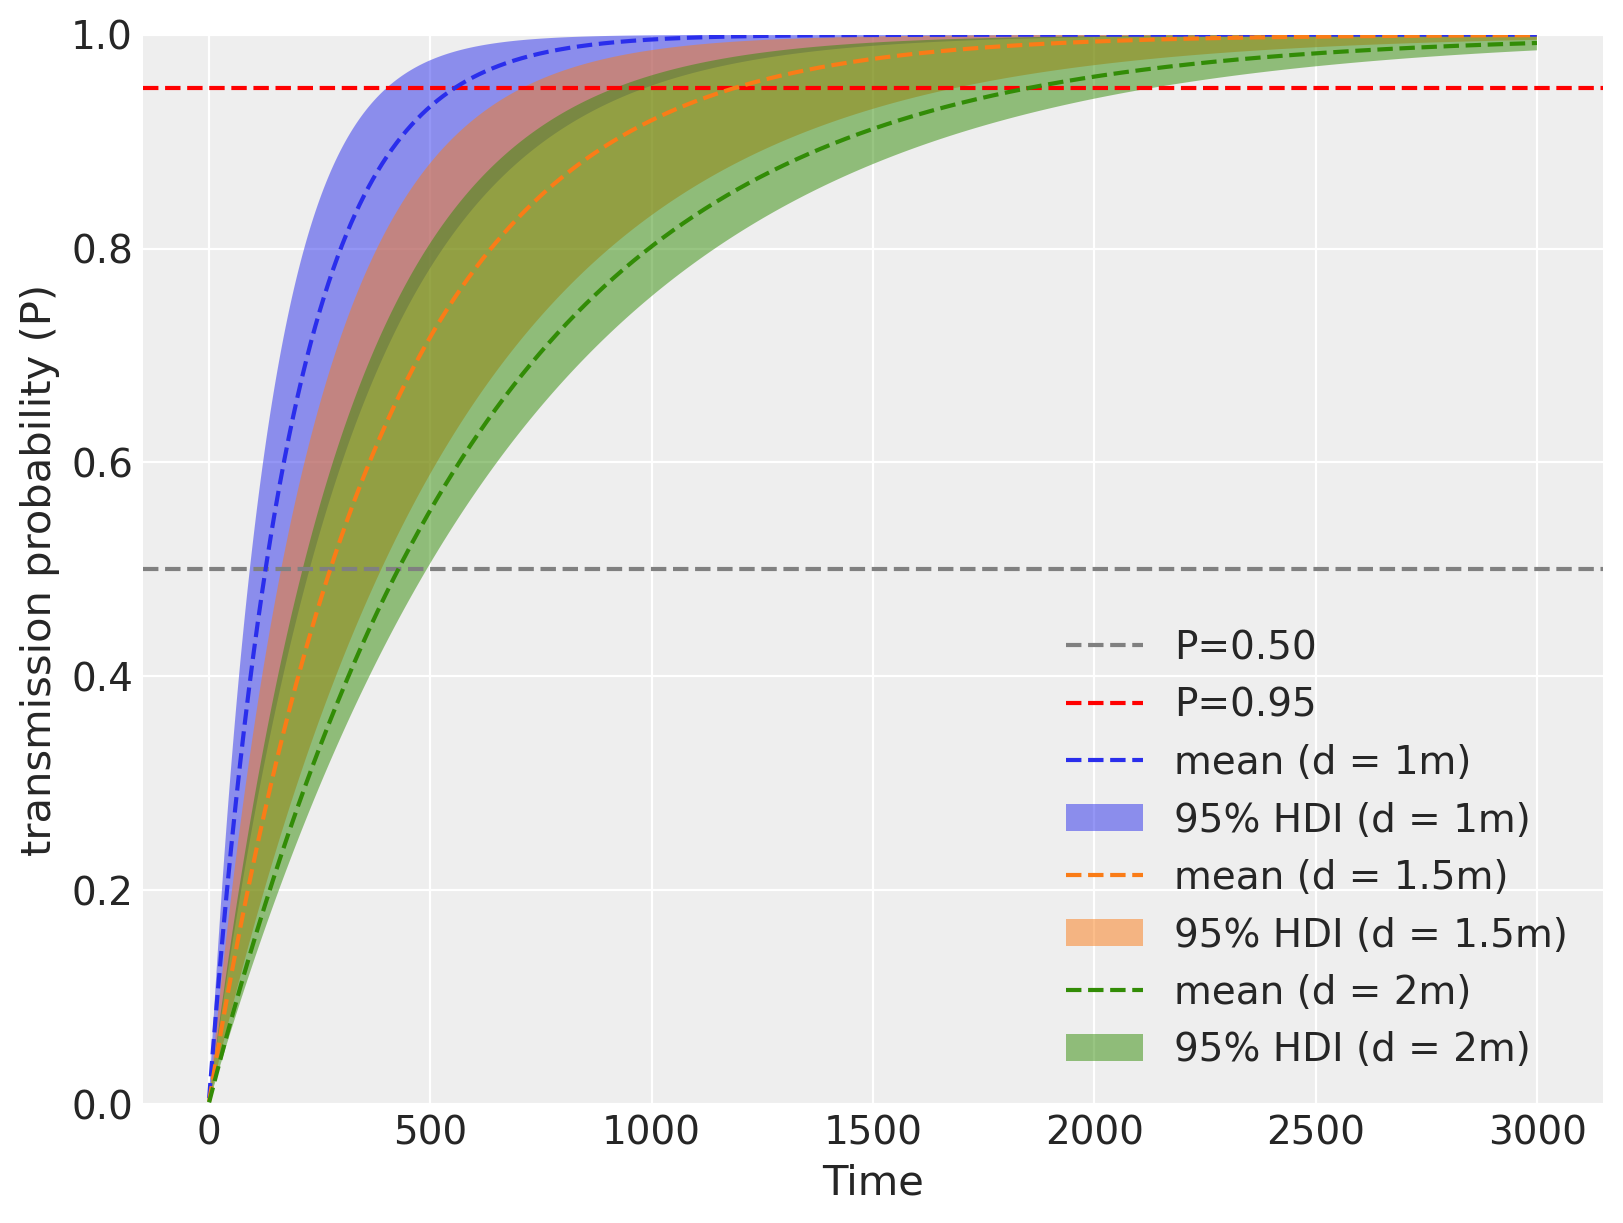

In [3]:
fig, ax = plt.subplots(figsize=(8,6))

ax.set_ylim([0, 1])
line1 = ax.axhline(0.5, color='gray', linestyle='--', label= 'P=0.50')
line2 = ax.axhline(0.95, color='red', linestyle='--', label= 'P=0.95')


line_1m = ax.plot(time, prob_env_1m, linestyle='--', label='mean (d = 1m)')
ax.fill_between(time, 
                1 - (1 - (lower_p0_1m * np.exp(- lower_lambda_1m * 1)))**time, 
                1 - (1 - (upper_p0_1m * np.exp(- upper_lambda_1m * 1)))**time,
                alpha=0.5, label='95% HDI (d = 1m)')

# curve for distance <= 1.5m
line_1_5m = ax.plot(time, prob_env_1_5m, linestyle='--', label='mean (d = 1.5m)')
ax.fill_between(time, 
                1 - (1 - (lower_p0_1_5m * np.exp(- lower_lambda_1_5m * 1)))**time, 
                1 - (1 - (upper_p0_1_5m * np.exp(- upper_lambda_1_5m * 1)))**time,
                alpha=0.5, label='95% HDI (d = 1.5m)')

# curve for distance <= 2m
line_2m = ax.plot(time, prob_env_2m, linestyle='--', label='mean (d = 2m)')
ax.fill_between(time, 
                1 - (1 - (lower_p0_2m * np.exp(- lower_lambda_2m * 1)))**time, 
                1 - (1 - (upper_p0_2m * np.exp(- upper_lambda_2m * 1)))**time,
                alpha=0.5, label='95% HDI (d = 2m)')

plt.legend()
plt.xlabel('Time')
plt.ylabel('transmission probability (P)')
#plt.title('Exposition time estimation : enveloppes')
plt.show()

In [ ]:
import numpy as np

#segmented

# 0.95
a = np.log(0.05)/np.log(1 - 0.002)
print(round(a))

# 0.5
b = np.log(0.5)/np.log(1 - 0.002)
print(round(b))

In [6]:
# 0.95

d = 1.5 
alpha =  0.0066
beta = 0.4455
c = np.log(0.05)/np.log(1 - (alpha * np.exp(- beta * d)))
print(round(c))


884
